## 1. Load and Clean the Data

Import the libraries needed.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Fix the seeds
SEED = 101
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# Set the batch size
batch_size = 64  
# Set the epochs number
epochs = 100  
# Latent dimensionality of the encoding space.
latent_dim = 256  
# Number of samples to use.
num_samples = 10000 

In [3]:
# Obtain the features (input) and labels (target)
input_texts = []
target_texts = []
# Unique characters in the inputs and targets
input_characters = set()
target_characters = set()
# Load the data into memory
with open('deu-eng.txt', "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
# Process line by line
for line in lines[: min(num_samples, len(lines) - 1)]:
    # Data format English + TAB + The Other Language + TAB + Attribution
    # It returns: English, The other language, and Attribution, which is discarded
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    # Get the unique char from the input texts
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    # Get the unique char from the target texts
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [4]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print(f'Number of samples:= {len(input_texts)}')
print(f"Number of unique input tokens: = {num_encoder_tokens}")
print(f"Number of unique output tokens: = {num_decoder_tokens}")
print(f"Max sequence length for inputs: = {max_encoder_seq_length}")
print(f"Max sequence length for outputs: = {max_decoder_seq_length}")

Number of samples:= 10000
Number of unique input tokens: = 71
Number of unique output tokens: = 85
Max sequence length for inputs: = 15
Max sequence length for outputs: = 45


Map Input and Target Characters to Numbers

In [5]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [6]:
input_token_index

{' ': 0,
 '!': 1,
 '"': 2,
 '$': 3,
 '%': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '0': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '5': 14,
 '6': 15,
 '7': 16,
 '8': 17,
 '9': 18,
 ':': 19,
 '?': 20,
 'A': 21,
 'B': 22,
 'C': 23,
 'D': 24,
 'E': 25,
 'F': 26,
 'G': 27,
 'H': 28,
 'I': 29,
 'J': 30,
 'K': 31,
 'L': 32,
 'M': 33,
 'N': 34,
 'O': 35,
 'P': 36,
 'Q': 37,
 'R': 38,
 'S': 39,
 'T': 40,
 'U': 41,
 'V': 42,
 'W': 43,
 'Y': 44,
 'a': 45,
 'b': 46,
 'c': 47,
 'd': 48,
 'e': 49,
 'f': 50,
 'g': 51,
 'h': 52,
 'i': 53,
 'j': 54,
 'k': 55,
 'l': 56,
 'm': 57,
 'n': 58,
 'o': 59,
 'p': 60,
 'q': 61,
 'r': 62,
 's': 63,
 't': 64,
 'u': 65,
 'v': 66,
 'w': 67,
 'x': 68,
 'y': 69,
 'z': 70}

In [7]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 '$': 4,
 '%': 5,
 "'": 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '0': 10,
 '1': 11,
 '2': 12,
 '3': 13,
 '4': 14,
 '5': 15,
 '6': 16,
 '7': 17,
 '8': 18,
 '9': 19,
 ':': 20,
 '?': 21,
 'A': 22,
 'B': 23,
 'C': 24,
 'D': 25,
 'E': 26,
 'F': 27,
 'G': 28,
 'H': 29,
 'I': 30,
 'J': 31,
 'K': 32,
 'L': 33,
 'M': 34,
 'N': 35,
 'O': 36,
 'P': 37,
 'Q': 38,
 'R': 39,
 'S': 40,
 'T': 41,
 'U': 42,
 'V': 43,
 'W': 44,
 'Y': 45,
 'Z': 46,
 'a': 47,
 'b': 48,
 'c': 49,
 'd': 50,
 'e': 51,
 'f': 52,
 'g': 53,
 'h': 54,
 'i': 55,
 'j': 56,
 'k': 57,
 'l': 58,
 'm': 59,
 'n': 60,
 'o': 61,
 'p': 62,
 'q': 63,
 'r': 64,
 's': 65,
 't': 66,
 'u': 67,
 'v': 68,
 'w': 69,
 'x': 70,
 'y': 71,
 'z': 72,
 '\xa0': 73,
 'Ä': 74,
 'Ö': 75,
 'Ü': 76,
 'ß': 77,
 'ä': 78,
 'ö': 79,
 'ü': 80,
 '’': 81,
 '“': 82,
 '„': 83,
 '\u202f': 84}

## 2 & 3. Encoder and Decoder for the model

In [8]:
# Initialize the 3 D matrix
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

# Convert the input texts and target texts to numerical values
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # Convert input texts to numerical values
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    # Pad the remaining using space that is mapped to 1
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    # Convert target texts to numerical values
    for t, char in enumerate(target_text):
        # decoder input is used to forecast decoder target
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    # Pad the remaining using space that is mapped to 1
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

## 4. Sequence to sequence model

In [9]:
## Begin Define the encoder layes
# Define an input sequence
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
# Define the LSTM which will return the hidden states
encoder = keras.layers.LSTM(latent_dim, return_state=True)
# Apply LSTM and return the ouputs and hidden states
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Discard the outputs and only keep the states.
encoder_states = [state_h, state_c]
## End Define the encoder layes


## Begin Define the decoder layes
# Define the decoder inputs
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
# Set up the decoder, using `encoder_states` as initial state.
# Kee the outputs and discard the hidden states
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# Forecast he decoder outputs using a classifier based on the decoder outputs
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
## End Define the decoder layes

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

Configure the model

In [10]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)


## 5. Train the Model

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
# Setup early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    min_delta=0.001, 
    mode='max'
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stopping],
)
# Save model
model.save("s2s.keras")

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.6124 - loss: 1.9515 - val_accuracy: 0.6047 - val_loss: 1.4827
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.6561 - loss: 1.2701 - val_accuracy: 0.6483 - val_loss: 1.2558
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.7046 - loss: 1.0882 - val_accuracy: 0.7131 - val_loss: 1.0599
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 0.7451 - loss: 0.9266 - val_accuracy: 0.7321 - val_loss: 0.9578
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.7645 - loss: 0.8349 - val_accuracy: 0.7445 - val_loss: 0.8950
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.7785 - loss: 0.7802 - val_accuracy: 0.7575 - val_loss: 0.8564
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.7865 - loss: 0.7501 - val_accuracy: 0.7694 - val_loss: 0.8209
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.7941 -

## 6. Evaluate model and check the fit

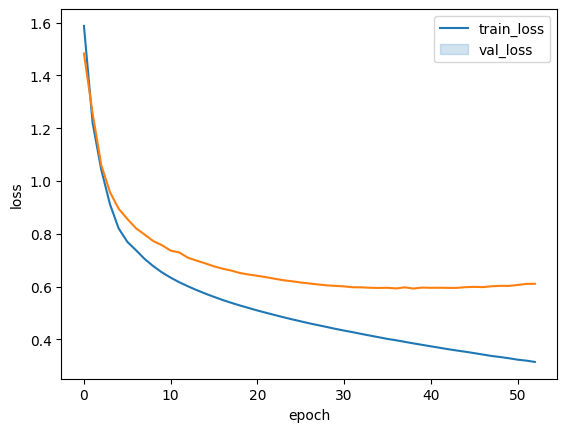

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

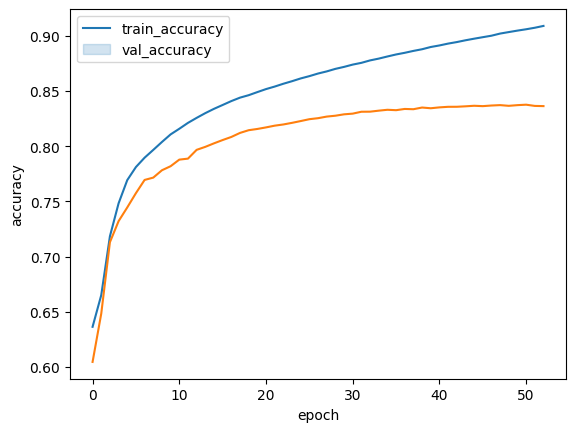

In [13]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## 7. Run the Inference

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, 71)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None, 85)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 256), (None,      │         335,872 │ input_layer[0][0]          │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, None, 256),       │         350,208 │ input_layer_1[0][0],       │
│                               │ (None, 256), (None, 256)] │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, None, 85)          │          21,845 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,415,852 (5.40 MB)

 Trainable params: 707,925 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 707,927 (2.70 MB)

In [16]:
# Define the inference models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s.keras")

# Set up the encoder model
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

# Set up the decoder layer
decoder_inputs = model.input[1]  # input_2
# Set up the inputs for the hidden states
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)

# The decoder model with inputs and states inputs with the context info
# The decoder model with outputs = decoder outputs and states with the context info
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [17]:
# Map the indicesto the corresponding characters
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [18]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        # forcast the outputs and hidden states
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Get the indices of the non-empty character
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Map the indices to the corresponding character
        sampled_char = reverse_target_char_index[sampled_token_index]
        # Concatenate the predicted char
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [19]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
-
Input sentence: Go.
Decoded sentence: Verzussenden!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38m